<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notes" data-toc-modified-id="Notes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notes</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Data-Ingest" data-toc-modified-id="Data-Ingest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Ingest</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#QA/QC" data-toc-modified-id="QA/QC-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>QA/QC</a></span></li><li><span><a href="#Classes" data-toc-modified-id="Classes-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Classes</a></span></li><li><span><a href="#Date" data-toc-modified-id="Date-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Date</a></span></li><li><span><a href="#Device" data-toc-modified-id="Device-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Device</a></span></li><li><span><a href="#Trends" data-toc-modified-id="Trends-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Trends</a></span></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Correlations</a></span></li><li><span><a href="#Save" data-toc-modified-id="Save-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Save</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Cut-off-Times" data-toc-modified-id="Cut-off-Times-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cut-off Times</a></span></li><li><span><a href="#Entity-Creation" data-toc-modified-id="Entity-Creation-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Entity Creation</a></span></li><li><span><a href="#Deep-Feature-Synthesis" data-toc-modified-id="Deep-Feature-Synthesis-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Deep Feature Synthesis</a></span></li><li><span><a href="#QA" data-toc-modified-id="QA-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>QA</a></span></li></ul></li><li><span><a href="#Training-Data" data-toc-modified-id="Training-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training Data</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data-Prep" data-toc-modified-id="Data-Prep-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Data Prep</a></span></li><li><span><a href="#xgboost" data-toc-modified-id="xgboost-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>xgboost</a></span><ul class="toc-item"><li><span><a href="#Naive-Model" data-toc-modified-id="Naive-Model-7.2.1"><span class="toc-item-num">7.2.1&nbsp;&nbsp;</span>Naive Model</a></span></li><li><span><a href="#Tuned-Model" data-toc-modified-id="Tuned-Model-7.2.2"><span class="toc-item-num">7.2.2&nbsp;&nbsp;</span>Tuned Model</a></span></li></ul></li><li><span><a href="#AutoML" data-toc-modified-id="AutoML-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>AutoML</a></span></li><li><span><a href="#Vanilla-FFNN" data-toc-modified-id="Vanilla-FFNN-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Vanilla FFNN</a></span></li></ul></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

# Notes

* Problem statment does not suggest device independence: these could be networked or interdependent systems, e.g. ordering.
* Failure class is HEAVILY imbalanced; modeling is prone to finding local optima that explain the majority class.
* [During failure, attributes 2, 4, 7, and 8 report much higher values than normal. This is not true of 1, 3, 5, 6, and 9](#failhard)
* [a1 and a6 are very unique](#uniqueness)
* [No duplicate data and no missing values](#missing)
* [Events may have natural ordering that needs to be preserved](#ordered)
* [Devices appear to come in types/classes](#deviceclasses)
* Attributes look to be aggregates except for a1
* [a2 & a4 ramp-up before failure, and looks like a7 spikes quickly too](#correlation)
* Some devices go through "servicing" where aggregate value drops
* [a3 & a9 are weakly positively correlated](#correlation)
* [a7 & a8 are perfectly positively correlated... because they are identical](#a7a8)
* [a7 appears to be critical in predicting failure in a naive model](#naivemodel)

# Setup

## Imports

In [152]:
# mute warnings
import warnings
warnings.filterwarnings('ignore')

# science
import scipy as sp
import numpy as np
import pandas as pd
import featuretools as ft
import xgboost as xgb
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import h2o
from h2o.automl import H2OAutoML

# system
import random
import hashlib
import pickle
import tempfile
import time

# visuals
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython import display

# options
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
sns.set_style('whitegrid')
sns.set_context('notebook')
sns_cmap = sns.diverging_palette(10, 220, sep=80, n=5)
pd.set_option('display.max_colwidth', -1)

# in case nb needs to be re-run
try:
    %load_ext autoreload
except:
    %reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [2]:
def load_data(filename):
    '''
    Load a generic CSV file into a pandas dataframe
    '''
    df = pd.read_csv(filename, escapechar='\\', encoding='utf-8')
    df['uuid'] = df.apply(lambda x: hashlib.md5(str(x.values).encode('utf-8')).hexdigest(), axis=1)
    assert sum(df.set_index('uuid').index.duplicated()) == 0, 'Error loading data: Hash collision; duplicate data'
    return df

In [3]:
def calculate_nan_values(orig_df):
    '''
    Parse a dataframe and report nan summary by column
    '''
    df = orig_df.copy()
    df = df.isna().sum(axis=0).reset_index()
    df.columns = ['column_name', 'na_count']
    df['na_ratio'] = df['na_count'] / orig_df.shape[0]
    df = df.loc[df['na_ratio'] > 0]
    df = df.sort_values(by='na_ratio')
    return df

In [4]:
def calculate_null_values(orig_df):
    '''
    Parse a dataframe and report null summary by column
    '''
    df = orig_df.copy()
    df = df.isnull().sum(axis=0).reset_index()
    df.columns = ['column_name', 'null_count']
    df['null_ratio'] = df['null_count'] / orig_df.shape[0]
    df = df.loc[df['null_ratio'] > 0]
    df = df.sort_values(by='null_ratio')
    return df

In [5]:
def value_limits(df, field, upper_bound=99, lower_bound=1):
    '''
    Find upper and lower percentile limits for a dataframe and field
    '''
    upper_limit = np.percentile(df[field].values, upper_bound)
    lower_limit = np.percentile(df[field].values, lower_bound)
    return upper_limit, lower_limit

In [6]:
def visualize_correlations(df, fields):
    '''
    Simplify the process of looking at a simple all-v-all correlation
    '''

    # keep a copy
    df = df.copy()

    # correlation coefficient of each column
    for field in fields:
        x_cols = [col for col in df.columns
                  if col != field and (df[col].dtype=='float64' or df[col].dtype=='int64')]
        labels = []
        values = []
        for col in x_cols:
            labels.append(col)
            values.append(
                np.corrcoef(df[col].values, df[field].values)[0, 1])

        # create dataframe for corr coeffs
        corr_df = pd.DataFrame({'col_labels': labels, 'corr_values': values})
        corr_df = corr_df.sort_values(by='corr_values')

        ind = np.arange(len(labels))
        fig, ax = plt.subplots(figsize=(12, 4))
        rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
        ax.set_yticks(ind)
        ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
        ax.set_xlabel('correlation coefficient')
        ax.set_title('Correlations with {}'.format(field))
        ax.set_xlim(-1, 1)
        plt.show()

In [7]:
def visualize_values(df, fields):
    '''
    Simplify the process of looking at a fields values
    '''
    
    # keep a copy
    df = df.copy()

    # iterate over fields
    for field in fields:

        # get limits of data
        ulimit, llimit = value_limits(df, field)
        print('###################')
        print('Working on field {}'.format(field))
        print('Upper limit: {:.3f}'.format(ulimit))
        print('Lower limit: {:.3f}'.format(llimit))

        # plot the ordered values for field
        plt.figure(figsize=(12, 8))
        plt.scatter(range(df.shape[0]), np.sort(df[field].values))
        plt.xlabel('index', fontsize=12)
        plt.ylabel(field, fontsize=12)
        plt.show()

        # plot histo of values
        sns.distplot(df[field].values, bins=50, kde=True, norm_hist=True)
        plt.xlabel(field, fontsize=12)
        plt.show()

In [8]:
def save_hdf5(df, hdf_file, table_name, format=None):
    '''
    Save a pandas dataframe as compressed HDF5
    '''
    if format is not None:
        df.to_hdf(
            hdf_file,
            table_name,
            mode='w',
            format=format,
            data_columns=True,
            complevel=9,
            complib='blosc:lz4')
    else:
        df.to_hdf(
            hdf_file,
            table_name,
            mode='w',
            data_columns=True,
            complevel=9,
            complib='blosc:lz4')

In [9]:
def train_xgb_model(X_train, y_train, params, kfolds=10, random_seed=7):
    '''
    Wrapper for fitting an xgb model with k-fold cv
    '''

    # setup
    random.seed(random_seed)
    np.random.seed(random_seed)

    # isolate train features
    X_train = X_train.values
    y_train = y_train.astype(int).values
    
    # stratified k-fold
    skf = StratifiedKFold(n_splits=kfolds, random_state=42, shuffle=False)
    best_score = 0
    best_model = None
    for i, (train_index, cv_index) in enumerate(skf.split(X_train, y_train)):
        print('Working on k-fold {}...'.format(i))
        
        # split data
        print('Splitting data')
        X_ktrain, X_kcv = X_train[train_index], X_train[cv_index]
        y_ktrain, y_kcv = y_train[train_index], y_train[cv_index]
        
        # Convert our data into XGBoost format
        print('Converting data to xgb format')        
        d_train = xgb.DMatrix(X_ktrain, label=y_ktrain, feature_names=feature_names)
        d_cv    = xgb.DMatrix(X_kcv, label=y_kcv, feature_names=feature_names)
        watchlist = [(d_train, 'train'), (d_cv, 'cv')]

        # train the model
        print('Modeling')
        model = xgb.train(params, d_train, num_boost_round=3000,
                          evals=watchlist, #feval=cohen_kappa_scorer,
                          early_stopping_rounds=300, verbose_eval=200)
        if model.best_score > best_score:
            best_score = model.best_score
            best_model = model
            model.save_model('xgboost_tuned.model')
        print('Done.')
    
    # testing
    return best_model

In [10]:
def cohen_kappa_scorer(preds, dmatrix):
    '''
    Stub for Cohen's Kappa as scoring metric for xgb
    '''
    y = dmatrix.get_label()
    cohen_kappa_score(preds, y)
    return 'kappa', score

In [11]:
def sensitivity(y_test, y_pred):
    '''
    Stub for a recall scorer for Keras
    Inspired by: http://www.deepideas.net/unbalanced-classes-machine-learning/ 
    '''
    true_positives = K.sum(K.round(K.clip(y_test * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_test, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [12]:
def specificity(y_test, y_pred):
    '''
    Stub for a precision scorer for Keras
    Inspired by: http://www.deepideas.net/unbalanced-classes-machine-learning/
    '''
    true_negatives = K.sum(K.round(K.clip((1-y_test) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_test, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# Data Ingest

In [19]:
# load data
faults_df = load_data("device_failure.csv")

In [20]:
# see a sample
faults_df.head()

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure,uuid
0,15001,S1F01085,215630672,56,0,52,6,407438,0,0,7,0,5646eb712abba53b99fd8b8152c8f503
1,15001,S1F0166B,61370680,0,3,0,6,403174,0,0,0,0,4eff5953a2d3610d43197ada2ea8002d
2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,0,f9b3e1204591b513e0f1aa53abd65dd9
3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,0,4c5c11b2f5e33fc3626c669b3ecb45d3
4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,0,a742b325beb173c3827e77ade95c157d


In [21]:
# rename columns for less typing
faults_df.columns = faults_df.columns.str.replace("attribute", "a")

In [22]:
# odd date format, did load reformat?
!head device_failure.csv

In [23]:
# basic summary for any obvious weirdness
faults_df.describe()

,date,a1,a2,a3,a4,a5,a6,a7,a8,a9,failure
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,15106.222798,1.223868e+08,159.484762,9.940455,1.741120,14.222693,260172.858025,0.292528,0.292528,12.451524,0.000851
std,78.412061,7.045960e+07,2179.657730,185.747321,22.908507,15.943021,99151.009852,7.436924,7.436924,191.425623,0.029167
min,15001.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,15040.000000,6.127675e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000,0.000000
50%,15086.000000,1.227957e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000,0.000000
75%,15168.000000,1.833084e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000,0.000000
max,15306.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000,1.000000


This data set appears to have attributes that are either "codes" or aggregates. The min/max and stddev for each is large, so there's a spread. If these are codes, one-hot encoding will be... tough.

# EDA

## QA/QC

In [ ]:
# double-check problem statement, one device per day?
check = faults_df.date.astype(str) + faults_df.device.astype(str)
assert len(check) == len(check.drop_duplicates()), 'More than one device per day'

In [ ]:
# inspect data types
dtype_df = faults_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

In [ ]:
# inspect uniqueness
uniqueness_df = pd.DataFrame(faults_df.nunique()).reset_index()
uniqueness_df.columns = ["column", "num_unique"]
uniqueness_df['perc_unique'] = uniqueness_df.num_unique.apply(lambda x: x/len(faults_df))
uniqueness_df

A1 is very unique: device identifier? Can't be. Must be a daily value. <a id="uniqueness"></a>

In [ ]:
# nulls
calculate_null_values(faults_df)

In [ ]:
# nan's (just to be sure)
calculate_nan_values(faults_df)

In [ ]:
# visualize column values
fields = [c for c in faults_df.columns if faults_df[c].dtype == 'int64']
visualize_values(faults_df, fields)

Some attributes have orders of magnitude higher values than others within same category. Must have units of measure.

In [ ]:
cols = faults_df.filter(regex='^a').columns.tolist()
temp = faults_df[cols]

In [ ]:
sns.pairplot(temp);

In [ ]:
sns.countplot(x="failure", data=faults_df)

Yikes, this is an extreme example of imbalanced classes.

## Classes

In [ ]:
# summary count of classes
100.*faults_df.groupby('failure').failure.count()/len(faults_df)

"Extreme" is putting it lightly: 99.91% of the time, the data indicates non-failure. **Model #1**: Always predict 'non-failure', you'll be right most of the time :)

In [ ]:
# summarize by class
temp = faults_df.filter(regex='^a|failure')
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(temp) 
temp.loc[:,:] = scaled_values
temp_melt = pd.melt(temp, "failure", var_name="measurement")

In [ ]:
sns.catplot(x="measurement", y="value", hue="failure", kind="bar", data=temp_melt);

Do some attributes have values ONLY when a failure occurs: a2, a4, a7, a8?

In [ ]:
# check this^^^ question
subtemp = temp.filter(regex='a2|a3|a9|a4|a7|a8|failure')
for c in subtemp.columns:
    subtemp.loc[subtemp[c] > 0, c] = 1
subtemp_melt = pd.melt(subtemp, "failure", var_name="measurement")
grouped = subtemp_melt.groupby(['measurement', 'failure']).sum()
grouped

Far more values present when not failing, so there must be a slant toward large values when there is a failure?

In [ ]:
sns.catplot(x="measurement", y="value", hue="failure", kind="bar", data=subtemp_melt);

<a id="failhard"></a>
Looks to be true. When there is a failure, attributes 2, 4, 7, and 8 report much higher values than normal. This is not true of 1, 3, 5, 6, and 9. They should be correlated with failure then...

In [ ]:
# Draw the heatmap with the mask and correct aspect ratio
corr = temp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

That is confidence building: a2, a4, a7, and a8 are weakly correlated with failure. Dig on A7==A8 in EDA.

## Date

In [ ]:
# what are the dates representing?
dates = faults_df.date
dates.unique()

Dates look like an arbitrary sequence <a id="ordered"></a>

In [ ]:
# is it sorted?
all(dates[i] <= dates[i+1] for i in range(len(dates)-1))

In [ ]:
# so these are ordered, arbitrarily assigned date representations spaced by...
pd.Series(dates.unique()).diff().unique()

 Can't create datetime augmentations: the day of week, time of month, etc. may be important, but I don't know the baseline date, so cannot hardcode unknown information.

In [24]:
# add order val in case its useful
faults_df.insert(0, 'order', range(0, len(faults_df)))

As long as a date transformation is applied uniformly such that relative information is preserved, creating a datetime object with an arbitrary reference is okay.

In [25]:
faults_df['datetime'] = faults_df['date'].apply(lambda x: pd.to_datetime(x, unit='d'))

## Device

In [ ]:
# isolate devices
devices = faults_df.device
devices.unique()

In [ ]:
# num of devices
len(devices.unique())

In [ ]:
# how many unique chars in each field of device name?
maxchars = max(devices.apply(lambda x: len(x)))
for nchar in range(0, maxchars):
    print('Char position {} :: num unique {}'.format(nchar,
                                                     len(devices.apply(lambda x: x[nchar]).unique())))

First four chars don't vary much; are there flavors of naming conventions, e.g. device classes?

In [ ]:
# group chars and calc uniqueness
maxchars = max(devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(devices.apply(lambda x: x[:nchars]).unique())))

There appear to be types of devices <a id="deviceclasses"></a>

In [26]:
# save the class1
faults_df['device_class1'] = faults_df.device.apply(lambda x: x[:3])

In [ ]:
faults_df.device_class1.unique()

In [ ]:
# remove class1 and look for more
sub_devices = devices.apply(lambda x: x[3:])
maxchars = max(sub_devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(sub_devices.apply(lambda x: x[:nchars]).unique())))

In [27]:
# maybe 4th char is a submodel, generation...? small enough to encode
faults_df['device_class2'] = faults_df.device.apply(lambda x: x[3])

In [ ]:
faults_df.device_class2.unique()

In [ ]:
# remove class1 and class2 and look for more
sub_devices = devices.apply(lambda x: x[4:])
maxchars = max(sub_devices.apply(lambda x: len(x)))
for nchars in range(1, maxchars):
    print('num chars {} :: num unique {}'.format(nchars,
                                              len(sub_devices.apply(lambda x: x[:nchars]).unique())))

In [28]:
# lump remainder together
faults_df['device_class3'] = faults_df.device.apply(lambda x: x[4:])

In [ ]:
faults_df.device_class3.unique()

In [ ]:
# check that original device == device clases
assert sum(faults_df.device != faults_df.device_class1 + faults_df.device_class2 + faults_df.device_class3) == 0, "Device classification failed"

## Trends

In [ ]:
# Rohrshach approach: "interactively" pick random device that had a failure and look at attribute trends in time
while True:
    try:
        temp = faults_df[(faults_df.failure == 1)]
        rand_device = temp.sample(1).device.values[0]
        temp = faults_df[(faults_df.device == rand_device)]
        temp = temp.filter(regex='^a|date$')
        temp['a1cs'] = temp.a1.cumsum()
        scaler = preprocessing.MinMaxScaler()
        scaled_values = scaler.fit_transform(temp)
        temp.loc[:,:] = scaled_values
        temp.plot(x='date', style='.-')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(3)
    except KeyboardInterrupt:
        break

+ a1 looks unaggregated, a daily value possibly -- need to add a1 cumulative sum feature
+ All other attributes **_appear_** to be aggregates -- verify below
+ a2 and a4 stand-out as ramping up before failure -- need to add linear trend feature at each time step
+ A few attributes appear to be correlated -- verify below <a id="correlation"></a>

Problem statement doesn't clearly specify if these are:
+ daily aggregates
+ aggregates of daily

In [31]:
# add cumulative sum feature just for a1
#faults_df['a1_cumsum'] = faults_df.sort_values(by=['device','order']).groupby('device').a1.cumsum()

# add for all
cols = faults_df.filter(regex='^a.$')
for col in cols:
    newcol = col+'_cumsum'
    faults_df[newcol] = faults_df.sort_values(by=['device','order']).groupby('device')[col].cumsum()

Do any values besides a1 go down?

In [ ]:
# sort, diff, and count
cols = ['a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'failure']
temp = faults_df.sort_values(by=['device','order']).groupby('device')[cols].diff()
temp.lt(0).sum()

There are a choice few: a2, a5, a7, a8, failure. The failures in particular mean they've been cleared/reset. If these are aggregate attributes as they appear, then values that drop, even if rarely, are experiencing some kind of remediation/service.

In [ ]:
# look at random example
a = random.choice(temp[(temp < 0).any(1)].index.tolist())
print(temp.loc[a])
print('\n*********************\n')
print('Look at index {}'.format(a))
b = faults_df[(faults_df.order == a)].device.values[0]
faults_df[(faults_df.device == b)]

Need to manually add feature to capture service history:
+ Cumulative sum of a* service count
+ Cumulative sum of a* service magnitude

In [33]:
# service features
cols = ['a2', 'a5', 'a7', 'a8']
for col in cols:
    
    # create columns and init
    service_mag = col+'_service_mag'
    service_count = col+'_service_count'
    faults_df[service_mag] = 0
    faults_df[service_count] = 0
    
    # fill with diff and remove natural agg
    faults_df[service_mag] = faults_df.sort_values(by=['device', 'order']).groupby('device')[col].diff().fillna(0)
    faults_df.loc[faults_df[service_mag] > 0, service_mag] = 0
    
    # denote service count and cumsum
    faults_df.loc[faults_df[service_mag] < 0, service_count] = 1
    faults_df[service_count] = faults_df.sort_values(by=['device','order']).groupby('device')[service_count].cumsum()
    faults_df[service_mag] = faults_df.sort_values(by=['device','order']).groupby('device')[service_mag].cumsum()

In [34]:
# handle failure manually to deal with naming convention change   
col = 'failure'
service_mag = 'f_clear_mag'
service_count = 'f_clear_count'
faults_df[service_mag] = 0
faults_df[service_count] = 0

# fill with diff and remove natural agg
faults_df[service_mag] = faults_df.sort_values(by=['device', 'order']).groupby('device')[col].diff().fillna(0)
faults_df.loc[faults_df[service_mag] > 0, service_mag] = 0

# denote service count and cumsum
faults_df.loc[faults_df[service_mag] < 0, service_count] = 1
faults_df[service_count] = faults_df.sort_values(by=['device','order']).groupby('device')[service_count].cumsum()
faults_df[service_mag] = faults_df.sort_values(by=['device','order']).groupby('device')[service_mag].cumsum()

## Correlations

In [ ]:
# look for correlations in numerical values
fields = [c for c in faults_df.columns if faults_df[c].dtype == 'int64']
visualize_correlations(faults_df, fields)

Indeed, some attributes are correlated, but A7 and A8 identical? <a id="a7a8"></a>

In [ ]:
# are attribute 7 and 8 identical?
a7_str = ''.join(faults_df.a7.astype(str).values)
a7_hash = hashlib.md5(a7_str.encode('utf-8')).hexdigest()
a8_str = ''.join(faults_df.a8.astype(str).values)
a8_hash = hashlib.md5(a8_str.encode('utf-8')).hexdigest()
a7_hash == a8_hash

This is telemetry data, so maybe A7 and A8 are the same measurement with different units, e.g. imperial and metric

In [35]:
# 7 was my fav num as a kid (Boomer Esiason wore it for the Bengals)
# drop attr8
drop_cols = faults_df.filter(regex='^a8').columns.tolist()
faults_df.drop(drop_cols, inplace=True, axis=1)

In [ ]:
# correlation matrix
corrmat = faults_df.corr(method='spearman')

# Draw the heatmap using seaborn
sns.clustermap(corrmat, vmax=0.6, vmin=-0.6, square=True, cmap=sns_cmap);

Weak similarities, but nothing so glaring we should break attributes apart.

## Save

In [36]:
faults_df.to_pickle('faults_df.pkl')

# Feature Engineering

Normally, we would put in a great deal of effort and time with SME's to build even more features. For example, cumulative sums of aggregated values over time should be important, and we can engineer such a set of features with:
```python
for col in ['a'+str(i) for i in range(1,10)]:
    newcol = col+'_cumsum'
    try:
        faults_df.drop([newcol], axis=1, inplace=True)
    except:
        pass
    try:
        faults_df[newcol] = faults_df.groupby(['device'])[col].cumsum()
    except:
        continue
```

However, what about all the other stats terms that may have embeded info (count, max, min, mean, stddev, etc.). This is laborious to construct all those features. Alternatively, we could use a carefully tuned NN architecture to find those features via the model. This is also laborious. Another option: create an ensemble of models that extract predictive information from features it creates.

As a start, let's instead try deep feature synthesis and drive the problem to the left (data) rather than to the right (model). This can be accomplished with time series using [tensor deep feature synthesis][tdfs].

[tdfs]: https://docs.featuretools.com/automated_feature_engineering/handling_time.html#creating-a-3-dimensional-feature-tensor-using-multiple-cutoff-times-from-make-temporal-cutoffs

## Cut-off Times

In [37]:
# list of unique devices
unique_devices = faults_df.filter(regex='device').drop_duplicates()
instance_ids = sorted(unique_devices.device.tolist())

# capture start dates per device -- ORDER MATTERS
device_start_dates = faults_df.sort_values(by=['device']).groupby('device')['datetime'].min().tolist()

# capture end dates per device -- ORDER MATTERS
device_end_dates = faults_df.sort_values(by=['device']).groupby('device')['datetime'].max().tolist()

# create reference data frame
cutoffs = pd.DataFrame(
    {
        'device': instance_ids,
        'start': device_start_dates,
        'end': device_end_dates,
    }
)

In [38]:
# gut check on 100 random entries that reassembly of dates and devices match
for n in range(0, 100):
    
    # pick random device
    rand_device = faults_df.sample(1).device.values[0]
    
    # get original min/max dates in np datetime
    min_test = faults_df[(faults_df.device == rand_device)]['datetime'].min().to_datetime64()
    max_test = faults_df[(faults_df.device == rand_device)]['datetime'].max().to_datetime64()
    
    # get cutoff values
    rand_min = cutoffs[(cutoffs.device == rand_device)].start.values[0]
    rand_max = cutoffs[(cutoffs.device == rand_device)].end.values[0]
    
    # compare
    assert rand_min == min_test, 'Date mismatch'
    assert rand_max == max_test, 'Date mismatch'

In [39]:
# for each device, begin at start and increment by 1-day until the end
temporal_cutoffs = ft.make_temporal_cutoffs(
    instance_ids=cutoffs['device'],
    start=cutoffs['start'],
    cutoffs=cutoffs['end'],
    window_size='1d')

In [40]:
# save
temporal_cutoffs.to_pickle('temporal_cutoffs.pkl')

## Entity Creation

In [41]:
# Create new entityset
es = ft.EntitySet(id='timeseries')

In [42]:
# create entity for faults
es = es.entity_from_dataframe(
    entity_id='faults',
    dataframe=faults_df,
    index='uuid',
    time_index='datetime')

In [43]:
es.normalize_entity(base_entity_id='faults',
                    new_entity_id='unique_devices',
                    index='device',
                    make_time_index=True,
                    additional_variables=["device_class1", "device_class2", "device_class3"])

Entityset: timeseries
  Entities:
    faults [Rows: 124494, Columns: 30]
    unique_devices [Rows: 1168, Columns: 5]
  Relationships:
    faults.device -> unique_devices.device

In [44]:
es.entities

[Entity: faults
   Variables:
     uuid (dtype: index)
     order (dtype: numeric)
     date (dtype: numeric)
     device (dtype: id)
     a1 (dtype: numeric)
     a2 (dtype: numeric)
     a3 (dtype: numeric)
     a4 (dtype: numeric)
     a5 (dtype: numeric)
     a6 (dtype: numeric)
     a7 (dtype: numeric)
     a9 (dtype: numeric)
     failure (dtype: numeric)
     datetime (dtype: datetime_time_index)
     a1_cumsum (dtype: numeric)
     a2_cumsum (dtype: numeric)
     a3_cumsum (dtype: numeric)
     a4_cumsum (dtype: numeric)
     a5_cumsum (dtype: numeric)
     a6_cumsum (dtype: numeric)
     a7_cumsum (dtype: numeric)
     a9_cumsum (dtype: numeric)
     a2_service_mag (dtype: numeric)
     a2_service_count (dtype: numeric)
     a5_service_mag (dtype: numeric)
     a5_service_count (dtype: numeric)
     a7_service_mag (dtype: numeric)
     a7_service_count (dtype: numeric)
     f_clear_mag (dtype: numeric)
     f_clear_count (dtype: numeric)
   Shape:
     (Rows: 124494, Columns: 

In [45]:
# save results
es.to_parquet('device_faults_entity_set')

Entityset: timeseries
  Entities:
    faults [Rows: 124494, Columns: 30]
    unique_devices [Rows: 1168, Columns: 5]
  Relationships:
    faults.device -> unique_devices.device

## Deep Feature Synthesis

In [46]:
# reload data
es = ft.read_parquet('device_faults_entity_set')
temporal_cutoffs = pd.read_pickle('temporal_cutoffs.pkl')
faults_df = pd.read_pickle('faults_df.pkl')

The below step can be parallelized using Dask (`n_jobs=-1`) since it's an embarassingly parallel problem due to independence:

$device_i \perp cutoff_j \perp feature matrix_j$

In [47]:
# reminder of the dfs primitives
ft.primitives.list_primitives()

,name,type,description
0,max,aggregation,Finds the maximum non-null value of a numeric feature.
1,std,aggregation,Finds the standard deviation of a numeric feature ignoring null values.
2,skew,aggregation,Computes the skewness of a data set.
3,sum,aggregation,Counts the number of elements of a numeric or boolean feature.
4,trend,aggregation,Calculates the slope of the linear trend of variable overtime.
5,count,aggregation,Counts the number of non null values.
6,median,aggregation,Finds the median value of any feature with well-ordered values.
7,time_since_last,aggregation,Time since last related instance.
8,avg_time_between,aggregation,Computes the average time between consecutive events.
9,percent_true,aggregation,Finds the percent of 'True' values in a boolean feature.


In [48]:
# primitive selections
agg_primitives=["mean", "median", "mode",
                "max", "min", "std", "skew",
                "count", "trend",
                "last", "time_since_last", "avg_time_between"]

# not obvious that transforms needed
# options, if so: "percentile", "time_since_previous", "multiply", "mod", "add", "subtract", "diff", "divide"
trans_primitives=[]

In [49]:
# don't waste time on data that isn't relevant
ignore_variables = {'faults': ['uuid',
                               'order',
                               'date',
                               'device_class1',
                               'device_class2',
                               'device_class3',
                               'failure']
                   }

I'm not going "deep" with stacking of feature primitives because tests suggest there is no additional information gained at the expense of time-consuming computation.

In [51]:
# create the feature tensor
feature_tensor, feature_defs = ft.dfs(
    entityset=es,
    target_entity='unique_devices',
    cutoff_time=temporal_cutoffs,
    cutoff_time_in_index=True,
    agg_primitives=agg_primitives,
    trans_primitives=trans_primitives,
    ignore_variables=ignore_variables,
    max_depth=1,
    max_features=-1,
    chunk_size="cutoff time",
    n_jobs=-1,
    verbose=True)

Built 197 features
EntitySet scattered to workers in 5.659 seconds
Elapsed: 05:54 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 306/306 chunks


distributed.nanny - WARNING - Worker process 6342 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6349 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6345 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6339 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6375 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6364 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6354 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6432 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6357 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6401 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6539 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6369 was killed by unknown signal
distributed.nanny - WARNING - Worker process 6443 wa

distributed.comm.core.CommClosedError: in <closed TCP>: ConnectionResetError: [Errno 104] Connection reset by peer
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: ConnectionResetError: [Errno 104] Connection reset by peer',)>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/distributed/comm/tcp.py", line 177, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p

distributed.comm.core.CommClosedError: in <closed TCP>: ConnectionResetError: [Errno 104] Connection reset by peer
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: ConnectionResetError: [Errno 104] Connection reset by peer',)>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/distributed/comm/tcp.py", line 177, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p

distributed.comm.core.CommClosedError: in <closed TCP>: ConnectionResetError: [Errno 104] Connection reset by peer
ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=CommClosedError('in <closed TCP>: ConnectionResetError: [Errno 104] Connection reset by peer',)>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/distributed/comm/tcp.py", line 177, in read
    n_frames = yield stream.read_bytes(8)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
tornado.iostream.StreamClosedError: Stream is closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/gen.py", line 1141, in run
    yielded = self.gen.throw(*exc_info)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p

In [53]:
# save intermediate output
hdf_file = 'raw_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(feature_tensor, hdf_file, table_name)

## QA

In [54]:
# clean-up data and don't disturb original
dfs_qa = feature_tensor.copy().reset_index()
dfs_qa.rename(columns={'time':'datetime'}, inplace=True)

In [55]:
# data in == data out
orig_len = len(dfs_qa)
new_len = len(feature_tensor)
assert orig_len == new_len, 'There is new or missing data'

The '1d' time windows in DFS automatically create steps in time where there may not be data, e.g.:
* original: [1 2 3 4 8 9]
* dfs: [1 2 3 4 **_5 6 7_** 8 9]

There are added values. Simply joing back against original dataframe (need to do anyways) fixes this.

In [56]:
# per problem statement, one device per day?
check = dfs_qa.datetime.astype(str) + dfs_qa.device.astype(str)
assert len(check) == len(check.drop_duplicates()), 'More than one device per day'

In [57]:
# rid ourselves of the junk datetime features due to arbitrary date assignment
dropcols = dfs_qa.filter(regex='DAY|MONTH|WEEKDAY|YEAR').columns.tolist()
nunique = dfs_qa.apply(pd.Series.nunique)
dropcols.extend(nunique[nunique == 1].index.tolist())
list(set(dropcols))

['MIN(faults.a7_service_count)',
 'MEDIAN(faults.f_clear_count)',
 'MAX(faults.f_clear_mag)',
 'MIN(faults.a2_service_count)',
 'MIN(faults.f_clear_count)',
 'MIN(faults.a5_service_count)',
 'MAX(faults.a5_service_mag)',
 'MAX(faults.a2_service_mag)',
 'MEDIAN(faults.f_clear_mag)',
 'MAX(faults.a7_service_mag)']

In [58]:
# drop them
dfs_qa.drop(dropcols, axis=1, inplace=True)

In [59]:
# merge dfs with original faults
faults_dfs_df = pd.merge(faults_df, dfs_qa, on=['device','datetime'], suffixes=('', '_y'))
assert len(faults_dfs_df) == len(faults_df), 'Something went wrong in merge'

In [60]:
# some duplicate columns in join
dropcols = faults_dfs_df.filter(regex='_y')
faults_dfs_df.drop(dropcols, axis=1, inplace=True)

In [61]:
# 10 min runtime for above on laptop, save output just in case
hdf_file = 'qa_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(faults_dfs_df, hdf_file, table_name, format='table')

# Training Data

In [62]:
# reload data
hdf_file = 'qa_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
Xy = pd.read_hdf(hdf_file, table_name)
feature_names = Xy.columns.tolist()

In [63]:
# some dfs are uniform
nunique = Xy.apply(pd.Series.nunique)
dropcols = nunique[nunique == 1].index.tolist()
sorted(dropcols)

[]

In [64]:
# remove uniform cols
if len(dropcols) > 0:
    Xy.drop(dropcols, axis=1, inplace=True)

In [65]:
Xy.head()

,order,date,device,a1,a2,a3,a4,a5,a6,a7,...,LAST(faults.a2_service_mag),LAST(faults.a2_service_count),LAST(faults.a5_service_mag),LAST(faults.a5_service_count),LAST(faults.a7_service_mag),LAST(faults.a7_service_count),LAST(faults.f_clear_mag),LAST(faults.f_clear_count),TIME_SINCE_LAST(faults.datetime),AVG_TIME_BETWEEN(faults.datetime)
0,0,15001,S1F01085,215630672,56,0,52,6,407438,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
1,1,15001,S1F0166B,61370680,0,3,0,6,403174,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
2,2,15001,S1F01E6Y,173295968,0,0,0,12,237394,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
3,3,15001,S1F01JE0,79694024,0,0,0,6,410186,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN
4,4,15001,S1F01R2B,135970480,0,0,0,15,313173,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,NaN


In [66]:
feature_names

['order',
 'date',
 'device',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a7',
 'a9',
 'failure',
 'uuid',
 'datetime',
 'device_class1',
 'device_class2',
 'device_class3',
 'a1_cumsum',
 'a2_cumsum',
 'a3_cumsum',
 'a4_cumsum',
 'a5_cumsum',
 'a6_cumsum',
 'a7_cumsum',
 'a9_cumsum',
 'a2_service_mag',
 'a2_service_count',
 'a5_service_mag',
 'a5_service_count',
 'a7_service_mag',
 'a7_service_count',
 'f_clear_mag',
 'f_clear_count',
 'MEAN(faults.a1)',
 'MEAN(faults.a2)',
 'MEAN(faults.a3)',
 'MEAN(faults.a4)',
 'MEAN(faults.a5)',
 'MEAN(faults.a6)',
 'MEAN(faults.a7)',
 'MEAN(faults.a9)',
 'MEAN(faults.a1_cumsum)',
 'MEAN(faults.a2_cumsum)',
 'MEAN(faults.a3_cumsum)',
 'MEAN(faults.a4_cumsum)',
 'MEAN(faults.a5_cumsum)',
 'MEAN(faults.a6_cumsum)',
 'MEAN(faults.a7_cumsum)',
 'MEAN(faults.a9_cumsum)',
 'MEAN(faults.a2_service_mag)',
 'MEAN(faults.a2_service_count)',
 'MEAN(faults.a5_service_mag)',
 'MEAN(faults.a5_service_count)',
 'MEAN(faults.a7_service_mag)',
 'MEAN(faults.a7_ser

In [67]:
# columns to encode
encode_cols = [
    'device_class1',
    'device_class2',
    'device_class3'
]

In [68]:
# one-hot encode the categoricals
Xy = pd.concat([Xy, pd.get_dummies(Xy[encode_cols])], axis=1)
Xy.drop(encode_cols, axis=1, inplace=True)

In [69]:
# junk features
dropcols = Xy.filter(regex='MODE\(faults.device_class')
Xy.drop(dropcols, axis=1, inplace=True)

In [70]:
# save intermediate output
hdf_file = 'model_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
save_hdf5(Xy, hdf_file, table_name)

# Modeling

This is a gnarly imbalanced class problem. Traditional options:
* Under-sample majority class: viable option since time-dependent values are encoded at every time step.
* Stratified resampling: viable option via xgboost.
* Over-sample minority class: this is time series data, so arbitrarily throwing out samples potentially removes valuable information about aggregations or leading indicators to failure.
* Synthesis: No. I intensely dislike manufacturing data unless there are strong underlying laws/principles, e.g. in physics, which constrain the fake data.

[imblearn][imb] is a good library to automate many of the methods needed and simplify the modeling exercise. Rather than go the route of "black box," I prefer to focus on the data at-hand and drive the problem toward features and not toward models.

[imb]:http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html

## Data Prep

In [71]:
# reload data from prior run as a quick start
faults_df = pd.read_pickle('faults_df.pkl')
hdf_file = 'model_dfs_feature_tensor.h5'
table_name = 'feature_tensor'
Xy = pd.read_hdf(hdf_file, table_name)

In [72]:
# ID cols to use in modeling
ignore = ['date', 'device', 'datetime']
ignore.extend(Xy.filter(regex='failure').columns)  # anything with failure info
predicting = 'failure'
predictors = [c for c in Xy.columns if (c != predicting and c not in ignore)]

# isolate y from X
y = Xy[predicting]
X = Xy[predictors]

# split data into train and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=7)

# remove uuid and track as index
idx_train = X_train.uuid.values
idx_test = X_test.uuid.values
X_train.drop('uuid', axis=1, inplace=True)
X_test.drop('uuid', axis=1, inplace=True)
feature_names = X_train.columns.values
assert set(feature_names) == set(X_test.columns.values), 'Train/Test feature name mismatch'

## xgboost

In [73]:
# make the train test vers for xgb
dtrain = xgb.DMatrix(X_train, y_train, feature_names=feature_names, nthread=-1)
dtest = xgb.DMatrix(X_test, y_test, feature_names=feature_names, nthread=-1)

### Naive Model

Before tuning, I want to be informed on what a simple model learns, and what an overfit model learns.

In [91]:
# define a naive model
xgb_params = {
    'objective': 'binary:logistic',
    'seed': 0
}
model = xgb.train(xgb_params, dtrain)

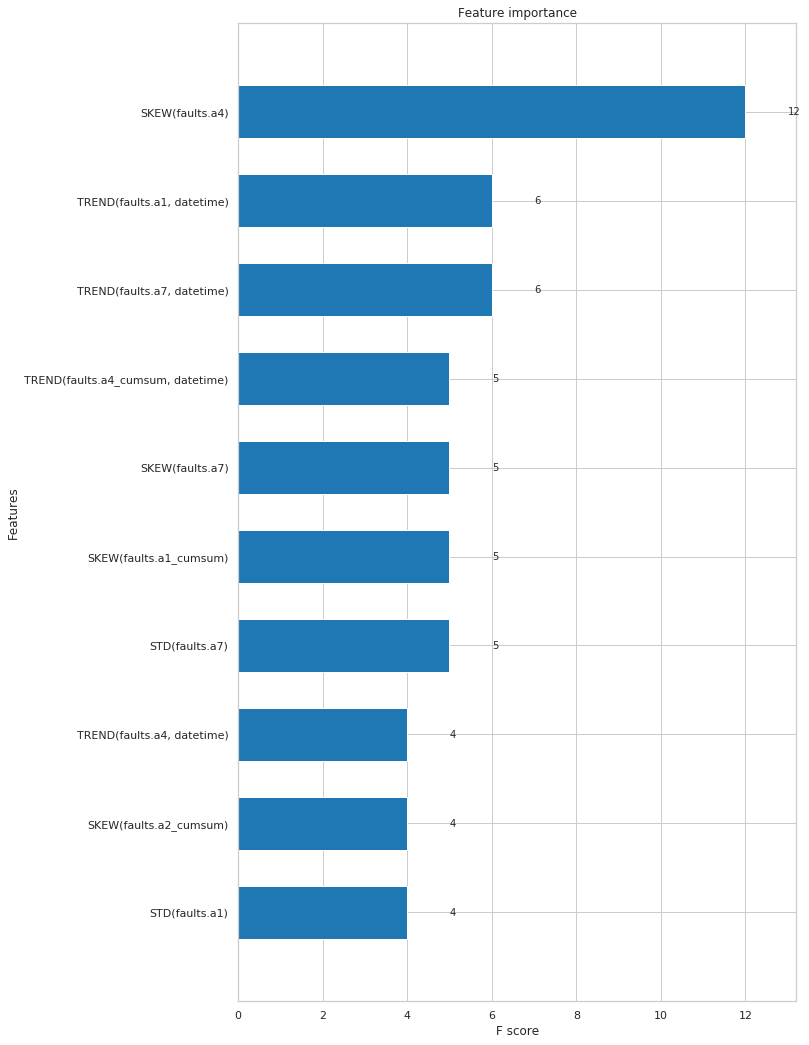

In [88]:
# plot the important features #
fig, ax = plt.subplots(figsize=(10, 18))
xgb.plot_importance(model, height=0.6, ax=ax, max_num_features=10)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=1)
plt.show()

<a id="#naivemodel"></a>
Is a7 really that important?

In [76]:
# prediction on test set
y_pred = model.predict(dtest)

In [77]:
# let's see if this makes sense
temp = faults_df.filter(regex='^a.$|failure')
scaler = preprocessing.MinMaxScaler()
scaled_values = scaler.fit_transform(temp)
temp.loc[:,:] = scaled_values
temp_melt = pd.melt(temp, "failure", var_name="measurement")
temp_melt.groupby(['measurement', 'failure']).std()

value
measurement failure          
a1          0.0      0.288607
            1.0      0.284269
a2          0.0      0.033024
            1.0      0.197078
a3          0.0      0.007454
            1.0      0.001266
a4          0.0      0.013304
            1.0      0.116142
a5          0.0      0.164365
            1.0      0.160281
a6          0.0      0.143869
            1.0      0.149966
a7          0.0      0.007882
            1.0      0.140665
a9          0.0      0.010238
            1.0      0.008205

Standard deviation for a7 is unusually larger when there's a failure.

### Tuned Model

In [92]:
# control for class imbalance
ratio = float(np.sum(y == 0)) / np.sum(y == 1)

# model params
params = {
    'max_depth': 9,
    'min_child_weight': 100,
    'subsample': 0.9,  # random sample %
    'colsample_bytree': 0.4,  # random col %
    'eta': 0.01,  # learning rate
    'reg_alpha': 0.5,  # L1 reg
    'lambda': 0.95,  # L2 reg
    'gamma': 0.1,  # loss split
    'seed': 6,
    'n_estimators': 1000,
    'scale_pos_weight': ratio,  # VERY IMPORTANT FOR THIS PARTICULAR PROBLEM
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'grow_policy': 'depthwise'
}

# train the model
model = train_xgb_model(X_train, y_train, params, kfolds=10)

Working on k-fold 0...
Splitting data
Converting data to xgb format
Modeling
[0]	train-auc:0.963561	cv-auc:0.731691
Multiple eval metrics have been passed: 'cv-auc' will be used for early stopping.

Will train until cv-auc hasn't improved in 300 rounds.
[200]	train-auc:0.999547	cv-auc:0.804559
[400]	train-auc:0.999801	cv-auc:0.820979
[600]	train-auc:0.999875	cv-auc:0.819505
Stopping. Best iteration:
[457]	train-auc:0.999824	cv-auc:0.837964

Done.
Working on k-fold 1...
Splitting data
Converting data to xgb format
Modeling
[0]	train-auc:0.971985	cv-auc:0.752361
Multiple eval metrics have been passed: 'cv-auc' will be used for early stopping.

Will train until cv-auc hasn't improved in 300 rounds.
[200]	train-auc:0.999787	cv-auc:0.877967
Stopping. Best iteration:
[6]	train-auc:0.997249	cv-auc:0.923627

Done.
Working on k-fold 2...
Splitting data
Converting data to xgb format
Modeling
[0]	train-auc:0.981801	cv-auc:0.852459
Multiple eval metrics have been passed: 'cv-auc' will be used for 

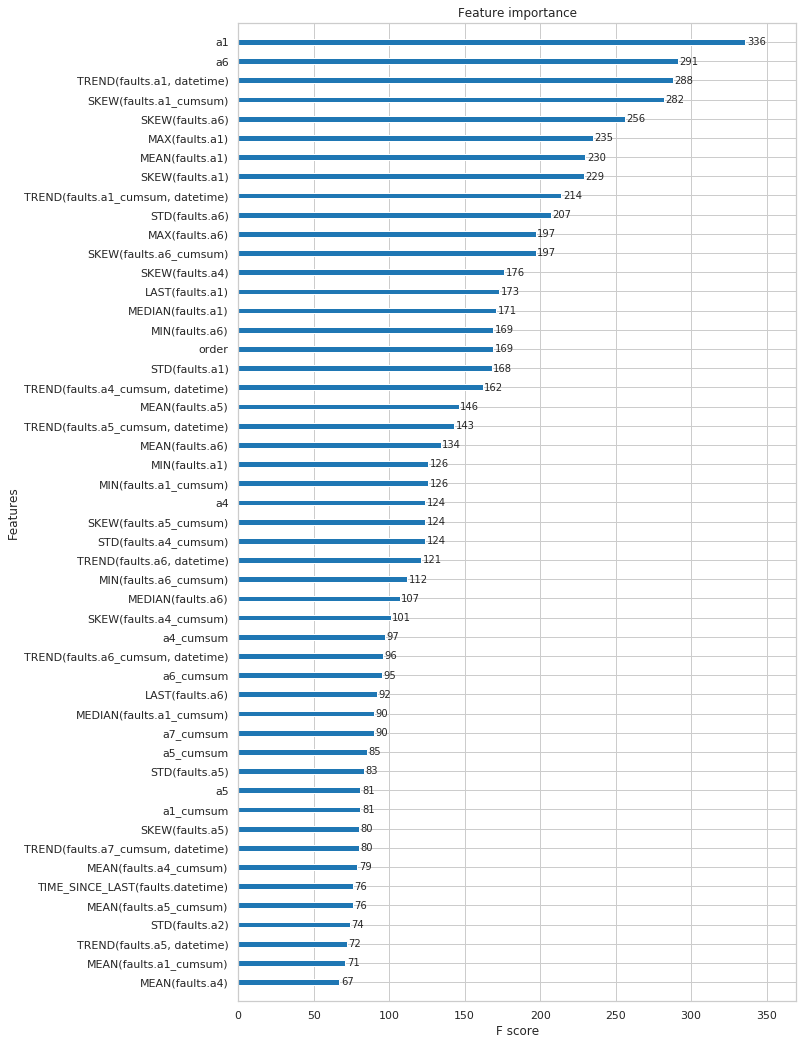

In [100]:
# feature importance plot
fig, ax = plt.subplots(figsize=(10, 18))
xgb.plot_importance(model, height=0.3, ax=ax, max_num_features=50)
fig.savefig('feature_importance.png', bbox_inches='tight', pad_inches=1)

In [101]:
# predict
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

In [138]:
# binary predictions
target_names = ['no fail', 'fail']
for prob_thresh in np.arange(0.48, 0.52, 0.01):
    y_pred_binary = [1 if x > prob_thresh else 0 for x in y_pred ]
    print(prob_thresh)
    print(metrics.classification_report(y_test, y_pred_binary, target_names=target_names))

0.48
             precision    recall  f1-score   support

    no fail       0.00      0.00      0.00     41040
       fail       0.00      1.00      0.00        44

avg / total       0.00      0.00      0.00     41084

0.49
             precision    recall  f1-score   support

    no fail       1.00      0.89      0.94     41040
       fail       0.01      0.66      0.01        44

avg / total       1.00      0.89      0.94     41084

0.5
             precision    recall  f1-score   support

    no fail       1.00      0.97      0.99     41040
       fail       0.02      0.55      0.04        44

avg / total       1.00      0.97      0.99     41084

0.51
             precision    recall  f1-score   support

    no fail       1.00      0.99      1.00     41040
       fail       0.06      0.32      0.10        44

avg / total       1.00      0.99      1.00     41084

0.52
             precision    recall  f1-score   support

    no fail       1.00      1.00      1.00     41040
       fa

In [207]:
prob_thresh, tn, fn, fp, tp = list(), list(), list(), list(), list()
for p in np.arange(0.484, 0.488, 0.0001):
    y_pred_binary = [1 if x > p else 0 for x in y_pred ]
    prob_thresh.append(p)
    cm = metrics.confusion_matrix(y_test, y_pred_binary)
    tn.append(cm[0][0])
    fp.append(cm[0][1])
    fn.append(cm[1][0])
    tp.append(cm[1][1])
tn = [float(i)/max(tn) for i in tn]
fp = [float(i)/max(fp) for i in fp]
fn = [float(i)/max(fn) for i in fn]
tp = [float(i)/max(tp) for i in tp]

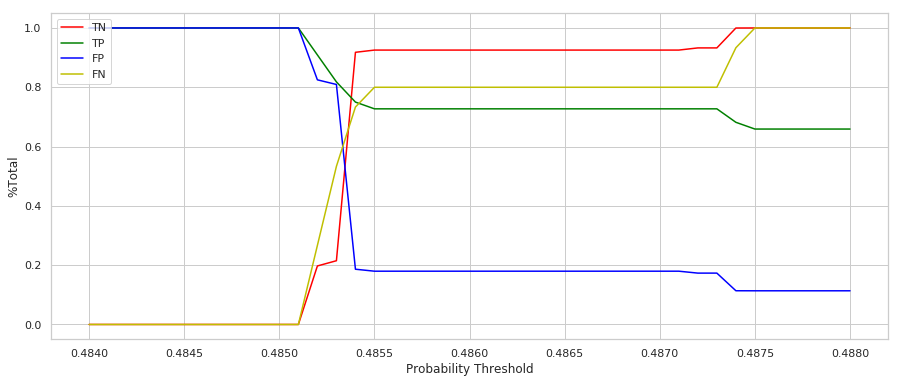

In [208]:
plt.plot(prob_thresh, tn, 'r', label='TN')
plt.plot(prob_thresh, tp, 'g', label='TP')
plt.plot(prob_thresh, fp, 'b', label='FP')
plt.plot(prob_thresh, fn, 'y', label='FN')
plt.legend(loc='upper left')
plt.xlabel('Probability Threshold')
plt.ylabel('%Total')
plt.show()

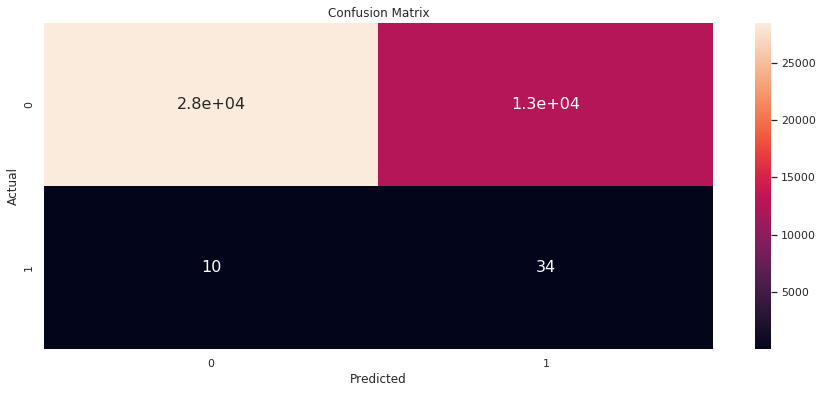

In [211]:
# arbitrarily select threshold
y_pred_binary = [1 if x >= 0.485372 else 0 for x in y_pred ]

# cm
ax = sns.heatmap(metrics.confusion_matrix(y_test, y_pred_binary), annot=True, annot_kws={"size": 16});
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

Text(0.5,1,'Binary Precision-Recall: Avg Precision=0.04')

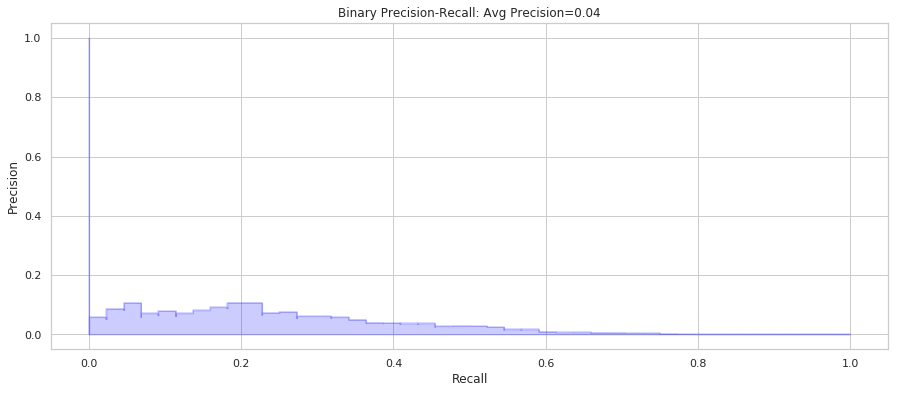

In [209]:
# visualize prec-recall
average_precision = metrics.average_precision_score(y_test, y_pred)
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Binary Precision-Recall: Avg Precision={0:0.2f}'.format(average_precision))

Presumably, we'd have acceptance criteria for the quality of the model and be able to discern if a 27% FN rate is "good" or "bad." Regardless, that's not a good rate and this model needs more tuning and we need more data/better features. However, if, for example, these are hyper-expensive machines, then we might lean toward a higher FP rate at the cost of unneeded service.

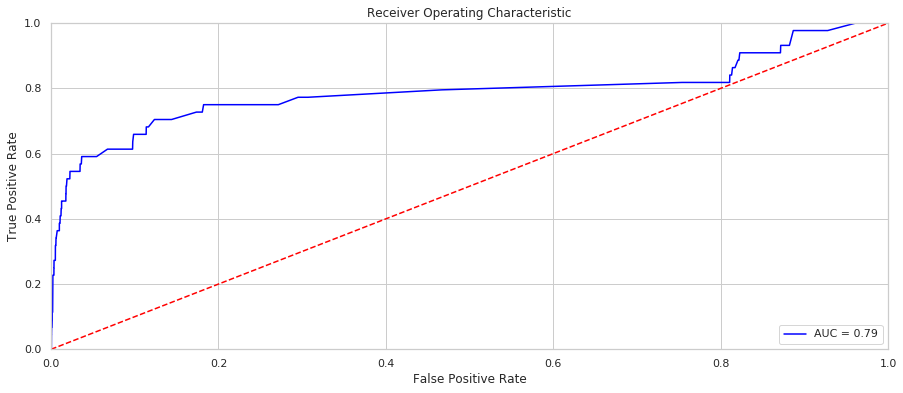

In [212]:
# roc
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## AutoML

I'm curious what features AutoML's stacked ensemble models suggest are important versus the tuned xgboost.

In [ ]:
# init the machine
h2o.init(min_mem_size_GB=16)
h2o.cluster().show_status()

In [ ]:
# create H2O's special df format
train_df_h2o = h2o.H2OFrame(Xy)

In [ ]:
# split data
train, test, valid = train_df_h2o.split_frame(ratios=[0.7, 0.15])

In [ ]:
# isolate predictors and predicting
x = train[predictors].columns
y = predicting

# make sure we have factors
train[y] = train[y].asfactor()
valid[y] = valid[y].asfactor()
test[y] = test[y].asfactor()

In [ ]:
# build a model (4h run time on p2.xlarge; use saved version)
#aml = H2OAutoML(max_runtime_secs=3600, balance_classes=True)
#aml.train(x=x,
#          y=y,
#          training_frame=train,
#          validation_frame=valid,
#          leaderboard_frame=test,
#          nfolds=10)

In [ ]:
# check leaderboard
aml.leaderboard

AutoML "likes" SKEW(a4) and STD(a7) like an earlier version of the tuned xgboost model harness did.

In [ ]:
# save the model
h2o.save_model(aml.leader, path="automl_leader_untuned.model", force=True)

In [ ]:
# reload the model
h2o_model = h2o.load_model('automl_leader_untuned_model/StackedEnsemble_AllModels_0_AutoML_20180801_153954')

In [ ]:
# isolate the metalearner model
metalearner = h2o.get_model(h2o_model.metalearner()['name'])

In [ ]:
# model details
metalearner

In [ ]:
# ensemble contribution
metalearner.coef_norm()

In [ ]:
# ensemble "weights"
metalearner.std_coef_plot()

In [ ]:
# predictions
y_pred = metalearner.predict(test)
y_pred = y_pred.as_data_frame().predict.tolist()
y_test = test[y].as_data_frame().failure.tolist()

In [ ]:
# visualize prec-recall
average_precision = metrics.average_precision_score(y_test, y_pred)
precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Binary Precision-Recall: Avg Precision={0:0.2f}'.format(average_precision))

Interesting exercise, but this model requires tuning as it has no predictive power.

In [ ]:
# cm
ax = sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16});
ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual');

In [ ]:
# roc
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# get sys resources back
h2o.cluster().shutdown()

## Vanilla FFNN

Why not? Effort, arch design, tuning, not enough data. Lots of reasons. If I were to go this route...

In [ ]:
# define I/O
input_size = len(featurenames)
output_size = 2

# a K.I.S.S. model
x = Input(shape=(input_size,))
layer1 = Dense(25, activation='relu')(x)
layer2 = Dense(10)(layer1)
layer3 = Dense(35)(layer2)
layer4 = Dense(10)(layer3)
layer5 = Dense(25, activation=None)(layer4)
layer6 = Dense(output_size)(layer5)
model = Model(x, layer6)
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(0.001),
    metrics=[sensitivity, specificity]
)

# weight the class imbalance
trade_off = 0.5  # for f-score
class_weight={
    0: 1,
    1: ratio * t
}

# run in 14 "day" batches
batch_size = len(X_train) / 14

# fit a model
model.fit(X_train,
          y_train,
          nb_epoch=500,
          batch_size=batch_size,
          class_weight=class_weight)

# Scratch